<a href="https://colab.research.google.com/github/Jasper-Hewitt/privatestuff/blob/main/ChiangWanan_Twitter_predict_unlabelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [ ]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 24.4 MB/s 
     |████████████████████████████████| 132 kB 68.9 MB/s 
     |████████████████████████████████| 182 kB 59.0 MB/s 
     |████████████████████████████████| 212 kB 63.6 MB/s 
     |████████████████████████████████| 127 kB 48.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 25.5 MB/s 
     |████████████████████████████████| 7.6 MB 52.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Unins

In [ ]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-roberta-wwm-ext"

if number_classes == 2:
    model_classifier = "Jiabo/Roberta_Chinese_sentiment"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [ ]:
model_classifier

'Jiabo/Roberta_Chinese_sentiment'

# 1. load and clean data

In [ ]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_ChiangWanan.xlsx

--2022-12-22 08:37:59--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_ChiangWanan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323135 (316K) [application/octet-stream]
Saving to: ‘scrap_ChiangWanan.xlsx’

scrap_ChiangWanan.x 100%[===================>] 315.56K  --.-KB/s    in 0.003s  

2022-12-22 08:37:59 (96.8 MB/s) - ‘scrap_ChiangWanan.xlsx’ saved [323135/323135]



In [ ]:
import pandas as pd

In [ ]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_ChiangWanan.xlsx')
testing_pd = testing_pd[['Text', 'Timestamp']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [ ]:
#dirty data
testing_pd

,text,Timestamp
0,台灣推新聞\n@mytwnews\n·\n51m爆料北市府多人留任蔣萬安小內閣 柯大笑：代表...,2022-12-10T03:09:52.000Z
1,Lu Authority Philosophy\n@archer_taiwan\n·\n1h...,2022-12-10T02:57:00.000Z
2,鉅石會\n@GoldenRockTW\n·\n1h中共對台文攻武嚇，近年變本加厲備受國際關注...,2022-12-10T02:49:02.000Z
3,吳奕軍 JasonWu\n@jasonbosox\n·\n1h中共對台文攻武嚇，近年變本加厲...,2022-12-10T02:48:00.000Z
4,台灣大叔\n@XjxjjxDjdjdj\n·\n4hReplying to \n@Felix...,2022-12-09T23:49:54.000Z
...,...,...
1471,台灣推新聞\n@mytwnews\n·\n18 Nov藍質疑曾赴中國醫學交流 陳時中競辦：轉...,2022-11-18T05:14:19.000Z
1472,李俊賢\n@jimlee32\n·\n18 Nov on \n@YouTube\n: 辭立委...,2022-11-18T05:03:36.000Z
1473,ysj Taiwan\n@tubbysong\n·\n18 Nov高虹安李忠庭列被告！高虹安...,2022-11-18T05:02:00.000Z
1474,三立iNEWS\n@inewsknowledge\n·\n18 Nov辭立委喊喊而已？蔣萬安...,2022-11-18T05:00:00.000Z


In [ ]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [ ]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text', 'Timestamp']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text,Timestamp
0,台灣推新聞\n\n·\n爆料北市府多人留任蔣萬安小內閣 柯大笑：代表我的局處長太優秀 - 自...,2022-12-10T03:09:52.000Z
1,\n\n·\n蔣萬安聽清楚了！\n:\n,2022-12-10T02:57:00.000Z
2,鉅石會\n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。\...,2022-12-10T02:49:02.000Z
3,吳奕軍 \n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。...,2022-12-10T02:48:00.000Z
4,台灣大叔\n\n·\n \n\n要檢討個人，趁現在還可以自由說話，快點大力檢討。\n以後共...,2022-12-09T23:49:54.000Z
...,...,...
1471,台灣推新聞\n\n·\n 藍質疑曾赴中國醫學交流 陳時中競辦：轉移蔣萬安矽谷經驗焦點 - 自...,2022-11-18T05:14:19.000Z
1472,李俊賢\n\n·\n \n\n: 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率...,2022-11-18T05:03:36.000Z
1473,\n\n·\n 高虹安李忠庭列被告！高虹安票太多嘲諷馬英九死亡之握？！台積電大舉投資棄台論...,2022-11-18T05:02:00.000Z
1474,三立\n\n·\n 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率也太差！吹噓矽谷經...,2022-11-18T05:00:00.000Z


## 1-2 Tokenization

In [ ]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
full_test_dataset = tokenized_datasets["test"]

# 2. preparing BERT


In [ ]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/958 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-24-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
import numpy as np

#prediction results


In [ ]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Timestamp, text. If Timestamp, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1476
  Batch size = 8


In [ ]:
pred

PredictionOutput(predictions=array([[-2.1086917,  1.2203352],
       [-2.2582111,  1.3552265],
       [-2.7559295,  2.0173798],
       ...,
       [ 2.229121 , -1.4934417],
       [ 3.796947 , -3.208681 ],
       [ 2.2763026, -1.5114912]], dtype=float32), label_ids=None, metrics={'test_runtime': 47.6811, 'test_samples_per_second': 30.956, 'test_steps_per_second': 3.88})

In [ ]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [ ]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,Timestamp,pred
0,台灣推新聞\n\n·\n爆料北市府多人留任蔣萬安小內閣 柯大笑：代表我的局處長太優秀 - 自...,2022-12-10T03:09:52.000Z,1
1,\n\n·\n蔣萬安聽清楚了！\n:\n,2022-12-10T02:57:00.000Z,1
2,鉅石會\n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。\...,2022-12-10T02:49:02.000Z,1
3,吳奕軍 \n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。...,2022-12-10T02:48:00.000Z,1
4,台灣大叔\n\n·\n \n\n要檢討個人，趁現在還可以自由說話，快點大力檢討。\n以後共...,2022-12-09T23:49:54.000Z,0
...,...,...,...
1471,台灣推新聞\n\n·\n 藍質疑曾赴中國醫學交流 陳時中競辦：轉移蔣萬安矽谷經驗焦點 - 自...,2022-11-18T05:14:19.000Z,0
1472,李俊賢\n\n·\n \n\n: 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率...,2022-11-18T05:03:36.000Z,0
1473,\n\n·\n 高虹安李忠庭列被告！高虹安票太多嘲諷馬英九死亡之握？！台積電大舉投資棄台論...,2022-11-18T05:02:00.000Z,0
1474,三立\n\n·\n 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率也太差！吹噓矽谷經...,2022-11-18T05:00:00.000Z,0


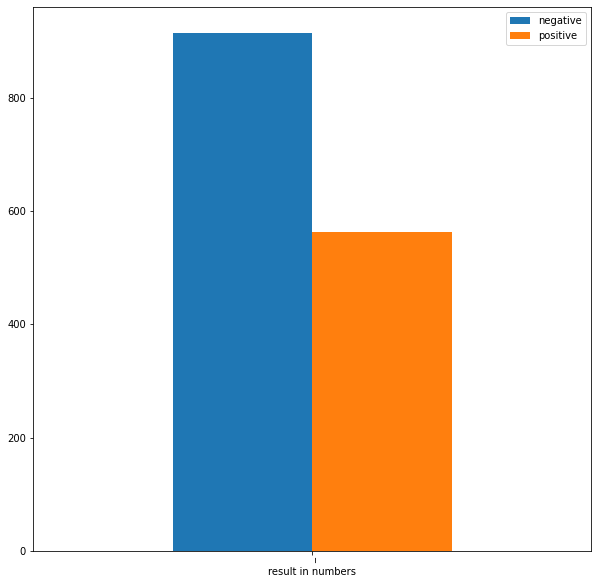

In [ ]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

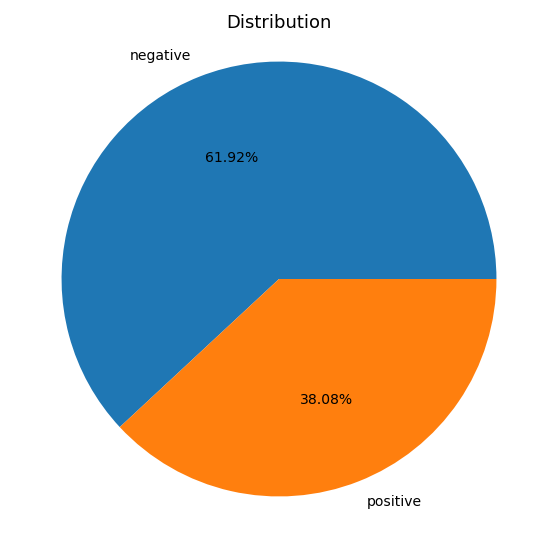

In [ ]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);